## Linear regression

This assignment is dedicated to Linear regression. 12 task, 30 points max.

By focusing on predicting different features of football players,
you will:
* gain understanding of mathematics behind Linear Regression model
* and become familiar with using `sklearn` library for solving this kind of tasks

In the assignment we will:
* build Linear regression models with 1 and many variables
* use both library methods and manual calculations using mathematical formulas
* implement main regression metrics to evaluate performance of our models
* explore limitations of classical linear regression

### Notes:
* do not modify `assert` blocks in code. They are used to check your results
    

### Data
- In this notebook we will work with Football Player attributes per each match played.
  
  Data is taken from [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) dataset. 
  
  The table used is `Player_Attributes`.


### Materias

Start with the assignment first. Use materials below as references when needed.

* NumPy:
    - [quickstart](https://numpy.org/doc/stable/user/quickstart.html)
    - [api reference](https://numpy.org/doc/stable/reference/index.html)
    

* Pandas:
    - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
    - guide on [groupby.transform](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation). 
      used in one of tasks on data preprocessing
    - [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
    

* sklearn:
    - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) class documentation
    - guide on [Linear models](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


* Matplotlib:
    - [cheatsheet](https://matplotlib.org/cheatsheets/)
    - examples of [main plot types](https://matplotlib.org/stable/plot_types/index.html)
    - [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) documentation

In [106]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size

import seaborn as sns
sns.set(font_scale=1.1)  # increase default font scale and set seaborn's plot style

from typing import List, Iterable

## Data Processing

In [107]:
data_root_dp = os.path.join('data')  # change to yours path
print(f'data_root_dp: "{data_root_dp}"')

data_root_dp: "data"


### read the raw SQL data
* you can run this code only once.<br>
  it will read `.sqlite` file and save extracted data to a more handy `.csv` format

In [108]:
# import sqlite3
#
# # open connection to .sqlite file
# data_sql_fp = os.path.join(data_root_dp, 'database.sqlite')
# print(f'will read from: "{data_sql_fp}"')
# con = sqlite3.connect(data_sql_fp)
#
# df = pd.read_sql('select * from Player_Attributes', con)  # run SQL-query
# print(f'shape: {df.shape}')
# con.close()  # close connection to .sqlite file
#
# # save to .csv
# out_fp = os.path.join(data_root_dp, 'tmp', 'player_attributes.csv')
# os.makedirs(os.path.dirname(out_fp), exist_ok=True)  # create directories if needed
# print(f'will save to: "{out_fp}"')
# df.to_csv(out_fp, index=False)

### read the  data

In [109]:
data_player_attributes_fp = os.path.join(data_root_dp, 'player_attributes.csv')
print(f'reading from: "{data_player_attributes_fp}"')
df = pd.read_csv(data_player_attributes_fp)
print(df.shape)

reading from: "data\player_attributes.csv"
(183978, 42)


In [110]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### basic data processing

In [111]:
# there are 3 'id' columns in data. 
# we will use 'player_api_id' only
# and drop other 'id' columns.
redundant_key_columns = ['id', 'player_fifa_api_id']

# also we will drop categorical columns for this task.
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

cols_to_drop = redundant_key_columns + categorical_columns
print(f'will drop following columns: {cols_to_drop}')
df.drop(columns=cols_to_drop, inplace=True)

# rename 'player_api_id' column to shorter one: 'id'.
df.rename(columns={'player_api_id': 'id'}, inplace=True)

# cast string values to datetime
df['date'] = pd.to_datetime(df['date'])

# drop records that contain only NaNs in features
all_features = set(df.columns).difference(['id', 'date'])  # all columns without key columns
df.dropna(subset=all_features, how='all', inplace=True)

print(f'df.shape: {df.shape}')

will drop following columns: ['id', 'player_fifa_api_id', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
df.shape: (183142, 37)


In [112]:
# the dataset we're working with migh get updated in future (new records might be added).
# thus we remove any records with date larger than the current max date in data (2016-07-07)
# for compatibility with current version of notebook.
df.drop(index=df[df['date'] > '2016-07-07'].index, inplace=True)
print(df.shape)

(183142, 37)


### drop duplicates

* we should **ALWAYS** understand what our data represents


* here we are dealing with Football Player attributes per each match played.

  so we expect the data to have `(id, date)` as a key
  
  
* let's check whether our assumption holds

In [113]:
df.duplicated(['id', 'date']).value_counts()

False    183142
dtype: int64

* there are no duplicates if considering `(id, date)` pair as a key

In [114]:
df.duplicated('id').value_counts()

True     172082
False     11060
dtype: int64

* and there are duplicates if considering only `id` column as a key

* so our assumption holds. but let's work only with latest stats for each player

#### Task 1. Keep only latest data for each player (1 point)

* HINT: you can use 

  `df[<new_column>] = df.groupby(<key_to_aggregate>)[<column>].transform('max')` 
  
  to get the `max` value of `<column>` for each group specified by `<key_to_aggregate>` columns.
  
  then you'll have to filter rows using `<column>` and `<new_column>` values
  

* don't forget to remove any additional columns you introduce here

In [115]:
# # your code here

df['latest_date'] = df.groupby(['id'])['date'].transform('max')
df.drop(index=df[df['date'] != df['latest_date']].index, inplace=True)
df.drop(columns=['latest_date'], inplace=True)

print(df.shape)

(11060, 37)


In [116]:
assert df.duplicated(['id']).sum() == 0
assert df.shape == (11060, 37)

In [117]:
# no longer need 'id' and 'date' columns
df.drop(columns=['id', 'date'], inplace=True)

### NaNs

In [118]:
df.isna().sum()

overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
dtype: int64

**Question:**
* do you see any pattern in how NaNs are distributed?

These are the players who have nan in all columns `'agility', 'balance', 'curve', 'jumping', 'sliding_tackle', 'vision', 'voleys'`. A player with nan in his columns is slightly more common than every 23. Each feature is explained as:

* **Agility** determines how quick and graceful a player is able to control the ball. Agility depends on both mental and physical skills of the player.
* **Balance** determines the even distribution of enabling a player to remain upright and steady when running, carrying and controlling the ball.
* **Curve** determines a player's ability to curve the ball when passing and shooting.
* **Jumping** determines a player's ability and quality for jumping from the surface for headers.
* **Sliding Tackle** determines the ability of performing sliding tackle of a player in a match.
* **Vision** determines a player's mental awareness about his teammates' positioning, for passing the ball to them.
* **Volleys** determines a player's ability for performing volleys.


In [119]:
df_full = pd.read_csv(data_player_attributes_fp)
print('{} rows that have at least one NaN in column'.format(df[df.isna().any(axis=1)].shape[0]))
df_with_nan = df_full[df_full.index.isin(df[df.isna().any(axis=1)].index)]
display(df_with_nan['date'].value_counts())
print('There are only 5 dates (which are very similar) where NANs meet among the latest player dates, '
      'although there are {} match dates in total'.format(
    df_full['date'].value_counts().shape[0]))

478 rows that have at least one NaN in column


2010-02-22 00:00:00    205
2008-08-30 00:00:00    100
2009-02-22 00:00:00     91
2009-08-30 00:00:00     80
2007-08-30 00:00:00      2
Name: date, dtype: int64

There are only 5 dates (which are very similar) where NANs meet among the latest player dates, although there are 197 match dates in total


This behavior may be due to the fact that the listed players did not perform the required action (although the characteristics vary greatly), played in the wrong positions, problems with access to information, and so on. The exact cause cannot be determined without further research, which is beyond the scope of this paper.

In [120]:
df.isna().sum(axis=1).value_counts()

0    10582
7      478
dtype: int64

#### Task 2. Drop rows that contain NaNs (1 point)

In [121]:
# your code here
df.drop(index=df[df.isna().sum(axis=1) > 0].index, inplace=True)

In [122]:
assert df.isna().sum().sum() == 0

## Task 3. Implement main regression metrics yourself (up to 4 points):
* Mean Squared Error (mse) - **(1 point)**
* Mean Absolute Error (mae) - **(1 point)**
* Mean Absolute Percentage Error (mape) - **(1 point)**
* R-squared (r2) - **(1 point)**


#### bonus point: MAPE is implemented in such way to take possible 0 in `y_true` into account
Hints:

* you should divide on 
  $ \hat{y}_{true} = (\hat{y}_{true}^{(0)}, \hat{y}_{true}^{(1)}, ..., \hat{y}_{true}^{(n)}) $,
  
  where $ \ \ \hat{y}_{true}^{(i)} = max(\ \ | y_{true}^{(i)} |, \ \ \epsilon), \ \ \epsilon > 0, \ \ y_{true}^{(i)} \in \mathbb R $
  

* for compatibility with `sklearn` take 

  `eps = np.finfo(np.float64).eps`
  
  
#### bonus point: $R^2$ is implemented in such way to take possible 0 in numerator and denominator into account
Hints:

* recall the formula: $ R^2 = 1 - \dfrac{SS_{residuals}}{SS_{total}} $


* you should return:

    $
    \begin{cases}
     R^2 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} \ne 0 
     \\
     0 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} = 0 
     \\
     1 & \text { otherwise }
    \end{cases}
    $
    

* for a better understanding of $R^2$ coefficient 
  try to explain to yourself why we return those values in each of edge cases

In [123]:
# we use '*' in the beggining of each function signature
# to forbid positional arguments and enforce the use of kwargs.
# this helps to avoid mistake when arguments are passed in wrong order.

# write down code instead of raising NotImplementedError in each of functions below.

def mse(*, y_true: np.ndarray, y_pred: np.ndarray):
    return ((y_true - y_pred)**2).sum() / y_true.shape[0]
    
def mae(*, y_true: np.ndarray, y_pred: np.ndarray):
    return np.abs(y_true - y_pred).sum() / y_true.shape[0]
    
def mape(*, y_true: np.ndarray, y_pred: np.ndarray):
    return np.abs((y_true - y_pred) /
                  np.maximum(y_true, np.finfo(np.float64).eps)
                  ).sum() / y_true.shape[0]
    
def r2(*, y_true: np.ndarray, y_pred: np.ndarray):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    if 0 not in (ss_res, ss_tot):
        return 1 - ss_res / ss_tot
    elif ss_res != 0 and ss_tot == 0:
        return 0
    else:
        return 1

#### Explanation of the returned values of the R-squared coefficient:
<br>
$ \text{Case 1} \ \ \text{if} \ \ SS_{residuals} \ne 0 \ \ \text{and} \ \ SS_{total} \ne 0 $

The coefficient of determination for a model with a constant takes values from 0 to 1. The closer the value of the coefficient to 1, the stronger the dependence. 0 - no dependence, 1 - absolute dependence
<br>
$ \text{Case 2 returns 0} \ \ \text{if} \ \ SS_{residuals} \ne 0 \ \ \text{and} \ \ SS_{total} = 0 $

The only case where $SS_{total}=0$ can be only if the average value of the array is equal to each of its elements, that is, a constant. The value from the experiment does not change each time, but the prediction says it does (it turns out it is not relevant). Then the $SS_{total}=0$ graph looks like a horizontal line, where at the same time $SS_{residuals}$ is not equal to zero. Hence there is no dependence, i.e. $y_{true}$ does not change.
<br>
$ \text{Case 3 returns 1} \ \ \text {otherwise} $

When $SS_{residuals}=0$ and $SS_{total} \ne 0$ ($y_{true}$ is not a constant) or both are zero, they are exactly the same and the dependence is absolute. That is, it indicates a complete coincidence of the prediction with the true values (or true values constant and there is an absolute coincidence with the prediction)

### Validate your implementations are correct

* we'll use synthetic data for this task


In [124]:
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)

In [125]:
def compare_metrics(fn, fn_lib, y_true, y_pred, n_digits=9):
    """ Print and compare values of custom and library functions using given precision. """
    m_fn = fn(y_true=y_true, y_pred=y_pred)
    m_fn_lib = fn_lib(y_true=y_true, y_pred=y_pred)
    print(f'{fn.__name__} custom : {m_fn}')
    print(f'{fn.__name__} library: {m_fn_lib}')
    print()
    assert round(m_fn, n_digits) == round(m_fn_lib, n_digits)

#### a case with a good fit

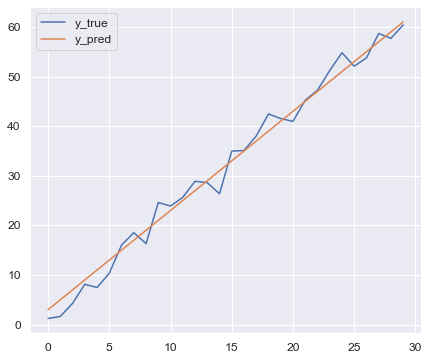

In [126]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [127]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 4.657582145553008
mse library: 4.657582145553008

mae custom : 1.7804171354048661
mae library: 1.7804171354048661

mape custom : 0.2051943408639863
mape library: 0.2051943408639863

r2 custom : 0.9858264739512386
r2 library: 0.9858264739512386

all tests passed


#### 0s in target. MAPE should explode

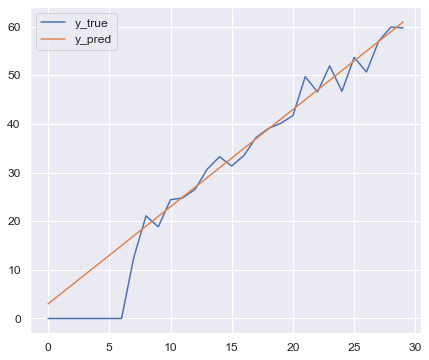

In [128]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_true[:7] = 0
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [129]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 26.54561529687955
mse library: 26.54561529687955

mae custom : 3.431567008558695
mae library: 3.431567008558695

mape custom : 9457559217478042.0
mape library: 9457559217478042.0

r2 custom : 0.9347921353303423
r2 library: 0.9347921353303423

all tests passed


#### edge cases for R2

In [130]:
# constant target value

n = 30
x = np.arange(n)
y_true = np.repeat(15, n)
y_pred = 2 * x + 3

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 0
r2 library: 0.0

success


In [131]:
# perfect fit

n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = y_true

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 1
r2 library: 1.0

success


### Define helper functions

In [132]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    """ A helper function to return all metrics for given labels and predictions. """
    
    # if you didn't implement some metrics, comment them out for this function to work.
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'mape': mape(y_true=y_true, y_pred=y_pred),
        'r2': r2(y_true=y_true, y_pred=y_pred),
    })

In [133]:
def fit_and_evaluate(model, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    """ 
    A helper function to: 
    * fit a passed model
    * and return metrics on train and test sets.
    """
    # fit the model
    model.fit(x_train, y_train)
    
    # return metrics as pd.DataFrame
    m = pd.DataFrame([
        get_metrics(y_true=y_train, y_pred=model.predict(x_train)),  # metrics for train set
        get_metrics(y_true=y_test, y_pred=model.predict(x_test))     # metrics for test set
    ], index=['train', 'test']
    )
    
    return m

## train/test split

* Split the data we have into Train and Test splits with 80%/20% proportion

In [134]:
print(df.shape)
ix_split = int(0.8 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(8465, 35) (2117, 35)


In [135]:
def get_train_test_data(
        features: List[str], target: str
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Return x_train, y_train, x_test, y_test using 
    * global train/test split 
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), 
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )

## Linear regression with 1 variable

* Let's start with Linear Regression that predicts target variable 
  using only 1 predictor (independent variable)  

* We will try to predict `dribbling` variable using `short_passing` as a predictor

In [136]:
target = 'dribbling'
features = ['short_passing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's visualize our data first

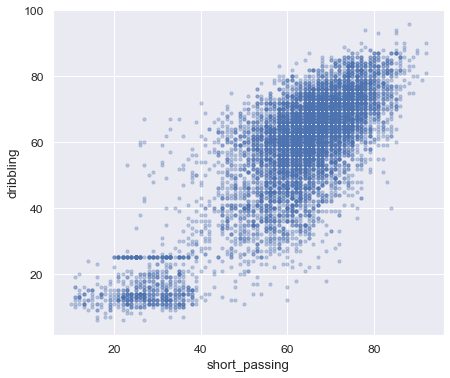

In [137]:
plt.scatter(x=x_train, y=y_train, alpha=0.3, s=10);
plt.xlabel('short_passing');
plt.ylabel('dribbling');

**Questions:**
* do you notice anything interesting on this plot?

There are some interesting things here. First, you can see a good correlation between the features. Second, more than half of the players have short_passing over 50 and dribbling over 40. Thirdly, there are no players with very bad characteristics (less than 10 for both features). But most importantly, there is a gap in the short_passing feature in the 40-50 range. Also the pronounced presence of a line for dribbling equal to about 32

* if so, how can we use it later to generate more accurate predictions?

I either haven't found the necessary interesting things with which to improve the prediction, or they don't exist, or I don't know it. I could suggest cutting off the lower region to keep the continuity of the characteristic dependence, but in my opinion you can't do that (remove some of the data for that reason)

### Task 4. Compute Pearson correlation coefficient between feature and target (1 pont)
Hint: you can use either `pd.Series.corr` method or `np.corrcoef` function

In [138]:
x_train.iloc[:, 0].corr(y_train)

0.8094048458494034

### Solve using `sklearn`

* we will use `LinearRegression` class from `sklearn` library 
  to fit a linear regression model and use it to generate prediction

In [139]:
from sklearn.linear_model import LinearRegression

In [140]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [141]:
model_intercept = model.intercept_
model_slope = model.coef_[0]
print(f'model_intercept: {model_intercept}')
print(f'model_slope: {model_slope}')

model_intercept: -6.211029905026159
model_slope: 1.0366141627766268


* use fitted model to get predictions for test set

In [142]:
model_preds = model.predict(x_test)
model_preds

array([55.98581986, 65.31534733, 44.58306407, ..., 62.20550484,
       54.9492057 , 76.71810312])

* explore model quality on test set.

In [143]:
print('model metrics on test set')
metrics_test_1 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_1

model metrics on test set


mse     108.345801
mae       8.173553
mape      0.205500
r2        0.681477
dtype: float64

**Question:**
* can you explain what those metic values mean?

**MSE** -- if we assume that we have a normal distribution, then in the range $\pm 108.34$ there are about 68% of values
**MAE** -- on average, the actual values deviate from the prediction by 8.17
**MAPE** -- on average, the actual values deviate from the prediction by 20.55 percent of the absolute value of the prediction
$R^2$ -- coefficient of 0.68 indicates that the features have a good correlation. This means that there is 68% less variation around the line than the mean. More details on the returned values can be seen above

#### Task 5. Calculate predictions for test set manually (1 point)

Above we used `LinearRegression.predict()` method to obtain predictions. 
Now let's do it manually!

Recall Linear Regression formula:

* $ \hat{y} = w_0 + w_1 \cdot x, $ 

    where:
    * $w_0$ is an intercept
    * $w_1$ is a slope
    * $x$ is a predictor
    * $\hat{y}$ is a predicted variable
  

* use intercept and slope values from fitted LinearRegression model

In [144]:
# use `x_test` for calculations as is (it's a DataFrame with 1 column).
# do not convert it to Series or numpy array.

# your code here:

model_manual_preds = pd.DataFrame(columns=[0])
model_manual_preds[0] = model_intercept + model_slope * x_test

In [145]:
assert isinstance(model_manual_preds, pd.DataFrame)

In [146]:
# ensure our manual predictions are the same as model generated
assert np.allclose(model_preds, model_manual_preds.iloc[:, 0].to_numpy())
print('success')

success


#### Task 6. Plot test data and predicted values (1 point)

* use `plt.scatter` function as in example above.
* first build scatter plot for test data
* then build scatter plot with model predictions
* add plot title, axis names and legend

Hints:
* use `alpha` parameter to control opacity and `s` parameter to control size of points.
  this will make plot more readable
* use `label` parameter to add label to each set of points added to scatter plot
* use different color for model predictions. control with parameter `color`

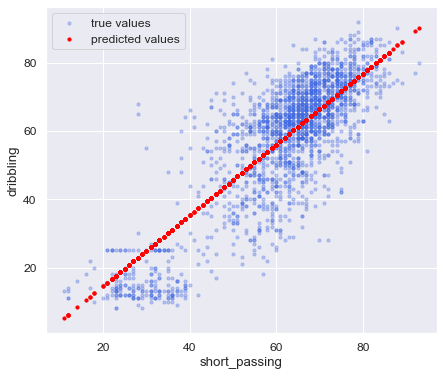

In [147]:
# # your code here
plt.scatter(x=x_test, y=y_test, alpha=0.3, s=10,
            label='true values', color='royalblue')
plt.scatter(x=x_test, y=model_manual_preds, alpha=1, s=10,
            label='predicted values', color='red')
plt.xlabel('short_passing') # todo: rename
plt.ylabel('dribbling') # todo: rename
plt.legend()

### Task 7.  Fit regression model manually (3 points)

So far we have used `sklearn` library to fit linear regression model and obtain predictions. Good job!

Recall the formula of Linear regression for 1 variable:

* $ \hat{y} = w_0 + w_1 \cdot x $

Now let's try to fit the model **ourselves**.

### Theory

Assume our dataset consists of _n_ samples.

To fit a Linear regression model means to find the best set of parameters - 
$(w_0, w_1)$ that minimizes a **Loss function**.<br>
In case of Linear regression we choose **Residual sum of squares (RSS)** as a Loss function:

* $ L(w, x, y) = RSS(w, x, y) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

That is conceptually the same as minimizing Mean squared error (MSE):

* $ MSE(w, x, y) = \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

Here:
* $y = (y_0, y_2, ..., y_{n-1}) $ - is a vector of target values we want to predict.
  1 value per each sample in our dataset that consists of _n_ samples
* $\hat{y} = (\hat{y}_0, \hat{y}_2, ..., \hat{y}_{n-1}) $ - is a vector of predictions 
* $\hat{y}_i = w_0 + w_1 \cdot x_i$ - is an individual prediction for _i_-th sample in a dataset

---

Best parameters $w_0$ and $w_1$ can be found using **following formulas**:

* $w_0 = \bar{y} - w_1 \cdot \bar{x}$


* $w_1 = \dfrac{\sum_{i=0}^{n-1}(x_i - \bar{x}) y_i}{\sum_{i=0}^{n-1}(x_i - \bar{x})^2}$


* where:
 * $\bar{x} = \dfrac{1}{n} \sum_{i=0}^{n-1}x_i$ - is the mean of vector $x$
 
 * $\bar{y} = \dfrac{1}{n} \sum_{i=0}^{n-1}y_i$ - is the mean of vector $y$
 
You should use these formulas to find the best model parameters in this task.
 
---

If you want to learn more you can refer to 
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) wiki-page.

It contains analagous formula for $w_1$ coefficient that is conceptually the same 
(so it's not a bug in our formula provided above).

### Implementation

* convert pd.DataFrame and pd.Series (`x_train` and `y_train` respecitvely) to numpy-arrays

In [148]:
x = x_train.iloc[:, 0].to_numpy()
y = y_train.to_numpy()

* calculate model parameters ($w_1$ - slope and $w_0$ - intercept) using formulas given above

In [149]:
# your code here:
manual_slope = ((x - x.mean()) * y).sum() / ((x - x.mean()) ** 2).sum()
manual_intercept = y.mean() - manual_slope * x.mean()

In [150]:
print(f'manual_intercept: {manual_intercept}')
print(f'manual_slope: {manual_slope}')

manual_intercept: -6.211029905026017
manual_slope: 1.0366141627766245


In [151]:
assert round(model_intercept, 9) == round(manual_intercept, 9)
assert round(model_slope, 9) == round(manual_slope, 9)
print('success')

success


## Linear regression with multiple variables

* Now let's use Linear Regression model that uses multiple variables

* We will try to predict `dribbling` variable using 
  `['ball_control', 'short_passing', 'strength', 'sprint_speed']` features

In [152]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's explore the data first

In [153]:
cols = features + [target]
print(cols)

['ball_control', 'short_passing', 'strength', 'sprint_speed', 'dribbling']


#### Task 8 (1 point)

Build pairwise correlation matrix for selected features and target. Visualize it with heatmap.

Hints:
* use `DF_TRAIN` to build statistics (`x_train` contains only features. target is in `y_train`)
* use `pd.DataFrame.corr()` to build correlation matrix
* use `sns.heatmap` to build heatmap from correlation matrix. 
  * use `center` parameter to center your heatmap's colormap at 0
  * use diverging colormap (`cmap` parameter)<br>
    you can find the list of diverging colormaps
    [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)<br>
    the reason is that we need to easily find both negative and positive correlations.
  * use `annot` parameters to add numbers to the plot.
* you can print `pd.DataFrame` and build plot in the same cell.<br> 
  use `display(...)` function that accets `pd.DataFrame` before building the plot
  
You can refer to [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) documentation

ball_control  short_passing  strength  sprint_speed  dribbling
ball_control       1.000000       0.904857 -0.024422      0.572677   0.919271
short_passing      0.904857       1.000000  0.039196      0.450801   0.809405
strength          -0.024422       0.039196  1.000000     -0.203386  -0.150197
sprint_speed       0.572677       0.450801 -0.203386      1.000000   0.656453
dribbling          0.919271       0.809405 -0.150197      0.656453   1.000000

<AxesSubplot:>

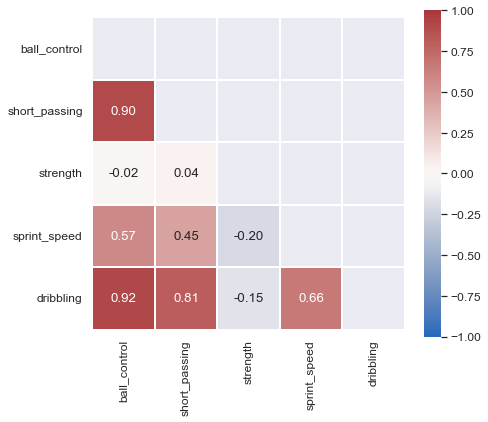

In [154]:
# your code here
correlation_matrix = DF_TRAIN[cols].corr()
display(correlation_matrix)
mask = np.triu(np.full(correlation_matrix.shape, True))
sns.heatmap(correlation_matrix,
            square=True, annot=True, fmt='.2f', center=0,
            linewidth=2, cmap='vlag', mask=mask, vmin=-1, vmax=1)

**Question:**
* what can you say about selected feature set using this correlation matrix?

Strength has a weak correlation with all other features, and ball control has a strong correlation with dribbling. In general, there is a good correlation between short passing, dribbling, and ball control

#### Let's build pairplots for features and target

* `plot_kws` parameter accepts dictionary of keyword arguments 
  that are passed to bivariate plotting function (`sns.scatterplot` in this case)


* we set size to 7 (using `s` parameter) to make points smaller and see patterns clearly.<br>
  you can compare this to running with not `plot_kws` passed.
  

* `alpha` parameter also helps to see data distribution clearly


* you can also experiment with `kind` parameter - refer to
  [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  documentation for possible values.

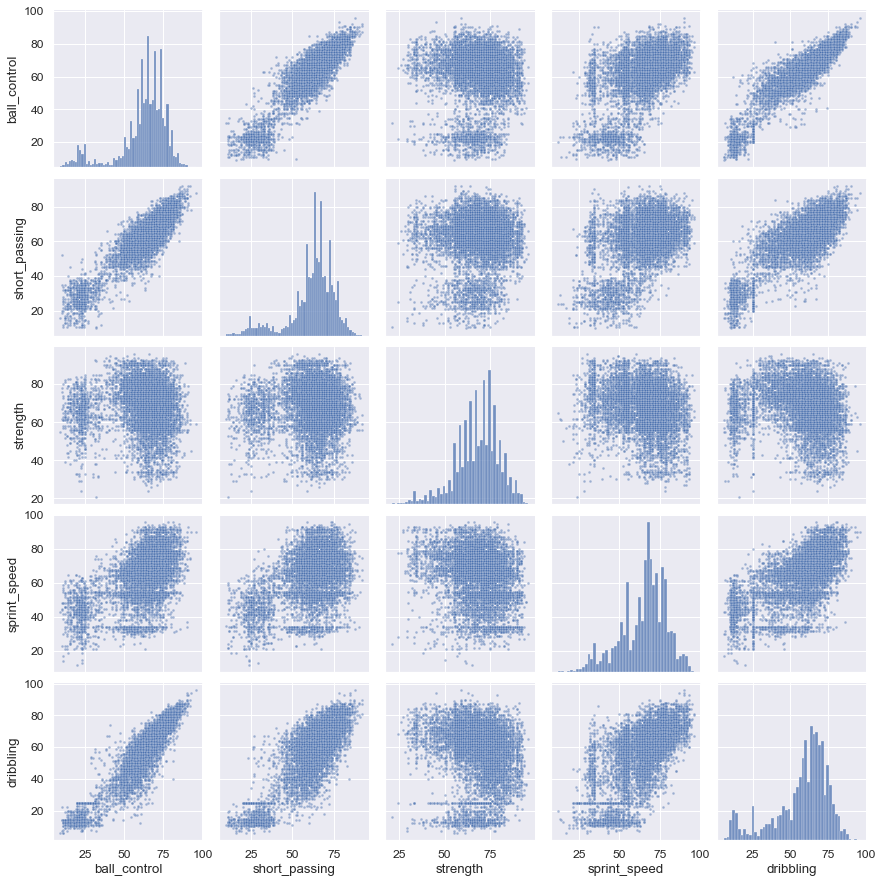

In [155]:
sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5});

**Questions:**
* what can you say about these scatterplots? is there anything we can use later?

Here we can generally draw the same conclusions as for the correlation matrix (see above). For example, there is also a good linear correlation between ball control and dribbling (also in the case of weak correlation, there should be a $\pm$uniform distribution across the graph). However, with these graphs we can see different patterns of dependencies, such as gaps, maybe the data can be grouped by area, and so on.

 ### Solve using `sklearn`

In [156]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [157]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: -4.4107609944965205
model_coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


**Question:**
* how to interpret these model parameters?

Intercept denotes the vertical shift of the line, when the other values indicate the slope of the straight line for different features

* use fitted model to get predictions for test set

In [158]:
model_preds = model.predict(x_test)
model_preds

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

* explore model quality on test set.

In [159]:
print('model metrics on test set')
metrics_test_2 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_2

model metrics on test set


mse     38.192447
mae      4.459334
mape     0.112574
r2       0.887719
dtype: float64

* Let's compare `metrics_test_2` against `metrics_test_1`

In [160]:
# combine 2 series in 1 dataframe
metrics_comparison = metrics_test_1.to_frame('LR_1v').join(metrics_test_2.rename('LR_mv')).T
metrics_comparison

mse       mae      mape        r2
LR_1v  108.345801  8.173553  0.205500  0.681477
LR_mv   38.192447  4.459334  0.112574  0.887719

C:\Users\Opiakos\AppData\Local\Temp\ipykernel_17196\2423771152.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  metrics_comparison.plot(


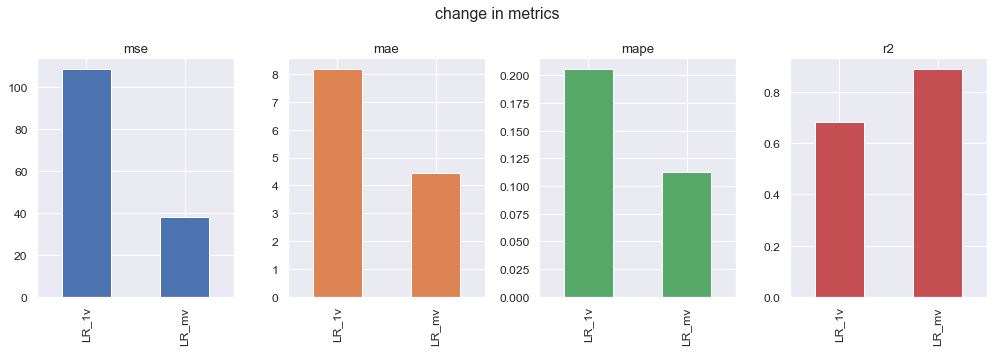

In [161]:
fig, ax = plt.subplots(figsize=(14, 5))  # specify figure size
metrics_comparison.plot(
    kind='bar', layout=(1,4), subplots=True, 
    title='change in metrics', legend=False, ax=ax
);
fig.tight_layout();  # prettify subplots. read more in documentation if interested

**Question:**
* did our Linear regression model improve after we've added more features?

Decreasing mse, mae and mape and increasing R-squared relative to the model with 1 predictor indicates that a more accurate prediction has been made

### Task 9. Implement Linear regression model with multiple variables yourself (5 points)

Okay, we've fitted Linear regression model using `sklearn` library. Now let's do the math ourselves!

### Prerequisites

For this task you will need to:
* have basic understanding of Linear algebra (operations with vectors and matrices)
* know how to perform matrix multiplication, transposition and inversion using `numpy` 
  (these functions can be found in NumPy documentation)
* carefully read the theory below and refer to wiki / textbooks / other sources if required

---

### Theory and notation

When we extend Linear regression model on case with $m$ variables we get the following formula:

* $ \hat{y}
= 1 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + ... + x_m \cdot w_m
= \sum_{i=0}^{m} x_i w_i
$,

where:
* $x = (1, x_1, ..., x_m)$ is an _(m+1)_-element feature vector. 
    * $x_0 = 1$ is a special term introduced in the beginning of feature vector 
      to add intercept to Linear regression model
    * $x_i, i=\overline{1,m}$ is an _i_-th feature value.
* $w = (w_0, w_1, ..., w_m)$ is an _(m+1)_-element parameter vector
    * $w_0$ - the first value of parameter vector - is referred to as **intercept**
* $\hat{y}$ is a predicted value

----

The formula above is used to calculate predictions for 1 sample.
i.e. we predict 1 scalar $\hat{y}$ from 1 feature vector $x$.

If we have a dataset of $n$ samples $(x, y)$ - we get a system of linear equations:

$
\begin{cases}
 \hat{y}^{(0)} = \sum_{i=0}^{m} x_i^{(0)} w_i \\
 \hat{y}^{(1)} = \sum_{i=0}^{m} x_i^{(1)} w_i \\
 ... \\\
 \hat{y}^{(n-1)} = \sum_{i=0}^{m} x_i^{(n-1)} w_i
\end{cases}
$

Such system can be rewritten in a succinct matrix form (a way that we write equations in Linear algebra):

* $ \hat{y} = X \cdot w $

And the task of minimizing Residual sum of squares (RSS) now looks:
* $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = \|y - X \cdot w \|_2^2 \rightarrow min $

Here:
* $y = (y^{(0)}, y^{(1)}, ..., y^{(n-1)})$ now denotes a **vector of target values** we want to predict<br>
  $y^{(j)}$ is a target value for _j_-th sample in a dataset.
* $\hat{y} = (\hat{y}^{(0)}, ..., \hat{y}^{(n-1)})$ 
  now denotes a **vector of predictions** <br>
  $\hat{y}^{(j)}$ denotes a predicted value for _j_-th sample in a dataset
* $X$ is a **feature matrix** of shape $n \times (m+1)$. <br>
  _n_ rows correspond to _n_ data samples and _m+1_ columns correspond to _m+1_ features that describe each sample.
* $w = (w_0, w_1, ..., w_m)$ is still a **model parameter vector**
* $X \cdot w$ denotes a **matrix-by-vector** multiplication
* $\|\cdot\|_2$ denotes an $L_2$-norm and is basically a square root of sum of squares of vector elements:<br>
  $\|a\|_2 = \sqrt{a_0^2 + a_1^2 + ... + a_{n-1}^2}$ for an _n_-component vector _a_.
  Thus, RSS means the same as before:<br>
  $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = 
  (y^{(0)} - \hat{y}^{(0)})^2 + (y^{(1)} - \hat{y}^{(1)})^2 + ... + (y^{(n-1)} - \hat{y}^{(n-1)})^2 = 
  \sum_{j=0}^{n-1} (y^{(j)} - \hat{y}^{(j)})^2
  $

Note:
* we now use **superscripts** $\hat{y}^{(i)}$ instead of **subscripts** $\hat{y}_i$ as before
  to denote _i_-th sample in a dataset
* it is done to be able to refer both to sample index (denoted by superscript)
  and feature index (denoted by subscript) in a single equation. 
  
  Thus:
  * $x^{(j)} = (1, x^{(j)}_1, x^{(j)}_2, ..., x^{(j)}_{m})$  now denotes 
    _j_-th feature vector in a dataset with _m+1_ features
  * $x_i^{(j)}$ denotes an _i_-th feature value of _j_-th feature vector
  * $X = 
  \begin{bmatrix}
      1 & x^{(0)}_1 & x^{(0)}_2 & ... & x^{(0)}_{m} \\
      1 & x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{m} \\
      ... \\
      1 & x^{(n-1)}_1 & x^{(n-1)}_2 & ... & x^{(n-1)}_{m}
    \end{bmatrix}
    $ is an $n \times (m+1)$ feature matrix. <br><br>
    $X$ can also be written as a column-vector of feature vectors:<br><br>
    $ X = \begin{bmatrix}x^{(0)} \\ x^{(1)} \\ ... \\ x^{(n-1)}\end{bmatrix} $

---

### Fit 

**<TL;DR\>** Enough notation! How can we fit this model?

By minimizin Residual sum of squares (RSS) for a Linear regression equation in a matrix form
we now get a **single** formula to find **all model parameters**!
* $ w = (X^T X)^{-1} X^T y $

Beautiful, isn't it? <br>
Recall, how we got individual formulas for $w_0, w_1$ in case of Linear regression with 1 predictor.<br>
Now we can find the whole parameter vector _w_ at once!

In the formula above:
* $X$ is an $n \times (m+1)$ dimensional feature matrix


* $X^T$ is a **transposed** feature matrix.<br>
  Transposition is a mathematical operation of "swapping" matrix dimensions.<br>
  So $X^T$ is an $(m+1) \times n$ dimensional matrix  


* $ (X^T X)^{-1} $ is the inverse matrix of $ X^T X $

Notes:
* Because of inversion operation performed on $X^T X$ matrix 
  there are difficulties in fitting Linear regression model in some cases.
  
  We will talk more on that later in the assignment.

---
    
If you want to learn more you can refer to 
[Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
wiki-page.

### Implementation

* implement `LRMatrixForm` class and `add_ones_column` function.<br>
  docstrings describe what each function/method should do - so read the docstrings.
  
  
* [what is a docstring?](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring)


Note:
* `LRMatrixForm` class must support 2 modes: **with** fitting intercept parameter and **without**.<br>
  The behavior is controlled by `fit_intercept` parameter passed to class constructor.

In [162]:
from sklearn.exceptions import NotFittedError

In [163]:
def add_ones_column(x: np.ndarray):
    """ 
    Add column consisting of ones to the beginning of matrix `x`. 
    Used when fitting `LRMatrixForm` with `fit_intercept` param set to True.
    """
    # HINTS: 
    # * create a vector that consists of ones: (1, 1, ..., 1)
    # * then use either `np.column_stack` or `np.hstack` function to add this vector to a matrix
    
    # your code here:
    return np.hstack((np.ones((x.shape[0], 1)), x))

class LRMatrixForm:
    """
    Class that encapsulates Linear regression model with multiplie variables.
    Calculations are performed using matrix formula.
    
    Use `fit()` method to fit the model on data.
    Use `predict()` method to calculate predictions when the model is fitted.
    """
    def __init__(self, fit_intercept: bool = True):
        """
        fit_intercept: 
        Whether to calculate the intercept for this model. 
        If set to False, no intercept will be used in calculations 
        (i.e. data is expected to be centered).
        """
        self.fit_intercept = fit_intercept
        self.w_ = None  # vector with all model parameters (intercept and weights)
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series):
        X = x_train.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            # when creating a model with intercept term we need to extend feature matrix
            # with a column consisting of ones (1, 1, ..., 1).
            X = add_ones_column(X)

        # your code here to calculate model parameters:
        self.w_ = np.matmul(
            np.matmul(
                np.linalg.inv(
                    np.matmul(
                        X.transpose(),
                        X)),
                X.transpose()),
            y_train.to_numpy())
        
    @property
    def coef_(self):
        """ Property that returns model parameters without the intercept term. """
        if self.w_ is None:
            raise NotFittedError()
        # your code here:
        if self.fit_intercept:
            return self.w_[1:]
        return self.w_
    
    @property
    def intercept_(self):
        """ Property that returns intercept term from model parameters. """
        if self.fit_intercept is not True:
            return 0.0  # for compatibility with sklearn
        if self.w_ is None:
            raise NotFittedError()
        # your code here:
        if self.fit_intercept:
            return self.w_[0]
        return 0.0
    
    def predict(self, x_test: pd.DataFrame):
        """ Generate predictions using fitted model parameters. """
        if self.w_ is None:
            raise NotFittedError()
        
        X = x_test.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            X = add_ones_column(X)

        # your code here to calculate predictions
        return np.matmul(X, self.w_)

### Validate your implementation is identical to library version

In [164]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.744076  4.423665  0.109928  0.879145
test   38.192447  4.459334  0.112574  0.887719

In [165]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: -4.410760994493857
coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


In [166]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values:

In [167]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean       -0.000265
std         6.181464
min       -19.832055
25%        -3.624840
50%        -0.929033
75%         2.657819
max        39.721074
Name: dribbling, dtype: float64

### Now let's compare `sklearn` model and yours with `fit_intercept=False`

In [168]:
model = LinearRegression(fit_intercept=False)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  38.001048  4.462836  0.111262  0.878322
test   38.417697  4.494385  0.114204  0.887057

In [169]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  38.001048  4.462836  0.111262  0.878322
test   38.417697  4.494385  0.114204  0.887057

**Questions:**
* Compare the metrics on a test set of a model fitted **with** intercept parameter
  vs model fitted **without** intercept.

To be honest, I do not see much difference, the difference in values is small, for example mse is 38 and 37 for no fit intercept and with its use, respectively

* Which model has a better performance? Can you explain why?

Here it is better with fit intercept because a situation may arise where there is a minimum possible predicted value, then an offset is necessary.

In [170]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.99382995 -0.05758452 -0.17865978  0.18315944]


In [171]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values again:

In [172]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.069583
std         6.199275
min       -20.437460
25%        -3.706841
50%        -0.888994
75%         2.766454
max        39.316868
Name: dribbling, dtype: float64

* compare this to the same statistics obtained with model fitted **with intercept**
* notice how the _mean_ value of difference changed

## Limitations of Linear regression

Recall the formula to find Linear regression parameters in case of multiple variables:
* $ w = (X^T X)^{-1} X^T y $

As noted above, there might be difficulties with fitting Linear regression model
because of inverting $X^T X$ matrix.

Not every matrix can be inverted.

An example of such case is when 2 or more features have strong linear relationship between them.<br>
It means that one of variables can be **linearly predicted from the others with a substantial degree of accuracy**.<br>
Such situation is named **collinearitry** (in case of 2 related variables)
or **multicollinearity** (>2 related features).<br>

Collinearity is associated with high value of correlation coefficient between 2 related features.

You can refer to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) 
wiki page to read more.

The intuition why multicollinearity is bad is that Linear Regression tries to capture 
a contribution of each individual feature to target independently of other features.
This is not possible with the data that has collinear features, 
as change in one such variable is always associated with change in other/others.

There are a whole bunch of really interesting thoughts that can help you 
to capture the intuition behind the concept of multicollinearity.<br>
You can find some of them 
[here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r).

### Collinearity

* Let's construct and add a new feature to our dataset that is going to be _collinear_ with another one:

In [173]:
# select features as usual
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [174]:
def add_collinear_column(_df: pd.DataFrame, orig_col: str, new_col: str):    
    """ 
    Construct new column as a linear transform of another one + tiny noise.
    y = f(x) = a1 * x + a2 + noise.
    
    Alternatively, we could apply no linear transform at all (set a1=1, a2=0)
    And only add some noise to existing column. Results would be the same.
    """
    # linear transform
    _df[new_col] = 2 * _df[orig_col] + 3
    # add tiny normal noise
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

orig_col = 'sprint_speed'
new_col = 'sprint_speed_2'
add_collinear_column(x_train, orig_col, new_col)
add_collinear_column(x_test, orig_col, new_col)
features.append(new_col)

In [175]:
corr_coef = np.corrcoef(x_train[orig_col], x_train[new_col])[0, 1]
print(f'correlation between {orig_col} and {new_col}: {corr_coef}')

correlation between sprint_speed and sprint_speed_2: 0.9999999999935513


* As expected, correlation coefficient between collinear features 
  (`sprint_speed` and `sprint_speed_2`) is close to 1.<br>
  Thus they are highly correlated.

In [176]:
# visualize sample of train data
check = x_train.sample(5).copy()
# add helper column to see how much noise was added
check['sprint_speed_2_wo_noise'] = 2 * check['sprint_speed'] + 3
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
20716          66.0           67.0      58.0          66.0      135.000167   
95613          64.0           46.0      64.0          78.0      158.999899   
91181          66.0           64.0      74.0          74.0      151.000042   
73891          55.0           52.0      85.0          64.0      131.000153   
45450          54.0           43.0      62.0          57.0      117.000190   

       sprint_speed_2_wo_noise  
20716                    135.0  
95613                    159.0  
91181                    151.0  
73891                    131.0  
45450                    117.0

### let's fit a Linear Regression model on this feature set:

In [177]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.743510  4.423829  0.109926  0.879147
test   38.192482  4.458874  0.112572  0.887719

* Both train and test metrics look reasonable
* Now let's explore model params:

In [178]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

intercept: 709.2342934783721
coef: [0.9822417076669558, -0.039313435868960286, -0.14442100357108104, 475.9703873125241, -237.88133260989184]


* Weights that correspond to `sprint_speed` and `sprint_speed_2` columns should have gone insanely high!


* That is not ok. Large weights and weights instability are the sign of 
    [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

    According to the definition, overfitting is:<br>
    "_the production of an analysis that corresponds too closely 
    or exactly to a particular set of data,<br>
    and may therefore fail to fit additional data 
    or predict future observations reliably_".
    
    
* But what does that mean? Let's try to generate predictions with our model.

### generate predictions using our fitted model

In [179]:
check = x_test.head(2).copy()
check[target] = y_test.head(2)
check['preds'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          52.0      106.999864   
147549          65.0           69.0      66.0          69.0      140.999901   

        dribbling      preds  
147541       49.0  44.339174  
147549       59.0  61.547960

In [180]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     14.107699
mae      3.604393
mape     0.069152
r2       0.435692
dtype: float64

* predictions look good, right? 

### but what if we change `sprint_speed` values a bit? let's add some small `delta`

In [181]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_2'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          53.0      106.999864   
147549          65.0           69.0      66.0          70.0      140.999901   

        dribbling      preds     preds_2  
147541       49.0  44.339174  520.309561  
147549       59.0  61.547960  537.518347

In [182]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     225556.255566
mae        474.913954
mape         8.864521
r2       -9021.250223
dtype: float64

* Wow, new predictions doesn't look even close to the target!<br>
  Our model doesn't look like a good model anymore.
  

* That is exactly what overfitting is. <br>
  **We fail to obtain reasonable predictions when we apply our model on new data**.

### One might notice that we have changed only 1 of 2 collinear features
* Indeed, giant model weights that correspond to these 2 features, should cancel each one out<br>
  if relation between feature values stays the same.  

* Let's check this out.<br>
  We have performed following transform:<br>
  `sprint_speed_changed = sprint_speed + delta`<br>
  

* How should we change `sprint_speed_2` to match the same data distribution from train data?<br>
  
  Let's calculate (we will ignore the noise added):  
  `sprint_speed_2_changed - sprint_speed_2 = f(sprint_speed_changed) - f(sprint_speed) =`<br>
  `= a1 * sprint_speed_changed + a2 - (a1 * sprint_speed + a2) = a1 * delta`

In [183]:
# here we change the second of collinear features 
# using the same coefficient 
# that was used in linear transform in `add_collinear_column()` function.
# we don't need to add intercept coefficient as it cancels it out (you can do the math yourself).
check['sprint_speed_2'] += 2 * delta
check['preds_3'] = model.predict(check[features])
check

ball_control  short_passing  strength  sprint_speed  sprint_speed_2  \
147541          51.0           60.0      68.0          53.0      108.999864   
147549          65.0           69.0      66.0          70.0      142.999901   

        dribbling      preds     preds_2    preds_3  
147541       49.0  44.339174  520.309561  44.546896  
147549       59.0  61.547960  537.518347  61.755682

* In the last example we see that new predictions (`preds_3`) now look similar to the first ones <br>
  (`preds` - calculated before changing `sprint_speed` value)

* So, if values of collinear features change accordingly - we are safe, right? <br>
  How do your think, can we always rely on this assumtion?

### What just happened

* The answer to the question above is: **no, we can't**.
  
  
* Yes, we have checked that if collinear features values are changed accordingly 
  (i.e. their **initial relation is preserved**), <br>
  model predictions look reasonable and accurate.
  
  But this will not always be the case on the real data.
  
  We can't be sure that the data 
  that we apply our fitted model on (`x_test`, for example)<br>
  preserves **exactly the same data distribution** as the data that model was trained on (`x_train`).
  
  

**Why this happened?**

* When feature matrix contains collinear or multicollinear features (the problem of **multicollinearity**),
  inversion of such a matrix is numerically unstable.<br>
  This leads to large values and imprecise estimates of model parameters.

**How to detect multicollinearity**
* You should monitor your model weights. For example using $L_2$ norm:<br>
  $ L_2(w) = \|w\|_2 = \sqrt{w_1^2 + w_2^2 + ... + w_n^2} = \sqrt{\sum_{i=1}^{n} w_i^2} $<br>
  If any of model weights are huge - $L_2$ norm will also have large value.
  
  
* Monitor model performance on validation data. 
  If the metrics are poor and prediction look huge,<br>
  you should check if collinear features are present in train data.

**How to fix the issue**

* For each set of collinear features, keep only 1 of them and remove the rest.<br>
  The best regression models are those in which the predictor variables each correlate highly 
  with the target variable,<br>
  but correlate at most only minimally with each other.
  

* Combine collinear features into new ones

  
* Use regularization (will be covered later in the course).

### Task 10. Implement function to calculate $L_2$-norm. (1 point)
* Use formula above to implement $L_2$ norm

In [184]:
def l2_norm(arr: Iterable):
    # your code here
    return np.sqrt(sum(map(lambda elem: elem ** 2, arr)))

### Calculate $L_2$-norm value for current model
* you should get high value that represents large values of some model parameters

In [185]:
l2_norm(model.coef_)

532.1055583288311

### Multicollinearity
  
* It's important to notice that in case of multicollinearity,
  correlation coefficient between each pair of related variables
  could be **not so high**.
  
  So **it may be hard to find multicollinear features in your data**.
  

* Let's visualize it in practice.

  We will build a new feature that has a strong linear relationship with 2 other features:
  $x_1 = a_0 + a_2 x_2 + a_3 x_3 + noise$

  We want to show that Linear regression model will still suffer from multicollinearity,<br>
  but correlation coefficients betweent each pair of multicollinear features will be **less close to 1**
  than it was in case of collinearity.

In [186]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

def add_collinear_column(_df: pd.DataFrame, col1: str, col2: str, new_col: str):    
    _df[new_col] = _df[col1] + _df[col2] + 5
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

add_collinear_column(x_train, col1='sprint_speed', col2='strength', new_col='foo')
add_collinear_column(x_test, col1='sprint_speed', col2='strength', new_col='foo')
features.append(new_col)

model = LinearRegression(fit_intercept=True)
m = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
display(m)
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

mse       mae      mape        r2
train  37.733406  4.423730  0.109978  0.879179
test   38.177947  4.458142  0.112519  0.887762

intercept: 5103.634848991807
coef: [0.9820577261262663, -0.03907638043160358, 1021.4611339654879, 1021.8132846249399, -1021.6056958897168]


* As before, model parameters for multicollinear features should be large

* Let's calculate $L_2$-norm value - it should also be large

In [187]:
l2_norm(model.coef_)

1769.509649783443

#### Task 11. Visualize correlation matrix for `x_train`  (1 point)
* Build annotated heatmap (use `annot` param to add values to plot, select diverging `cmap` and center it at 0)
* You should see that `foo` feature is correlated with ones it was created from,<br>
  but each of these correlation coefficients **is not so close to 1**

ball_control  short_passing  strength  sprint_speed       foo
ball_control       1.000000       0.904857 -0.024422      0.572677  0.474099
short_passing      0.904857       1.000000  0.039196      0.450801  0.415056
strength          -0.024422       0.039196  1.000000     -0.203386  0.541851
sprint_speed       0.572677       0.450801 -0.203386      1.000000  0.712702
foo                0.474099       0.415056  0.541851      0.712702  1.000000

<AxesSubplot:>

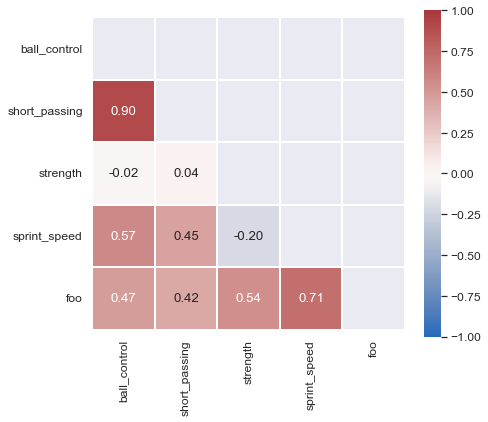

In [188]:
# your code here
correlation_matrix = x_train.corr()
display(correlation_matrix)
corr_mask = np.triu(np.full(correlation_matrix.shape, True))
sns.heatmap(correlation_matrix,
            square=True, annot=True, fmt='.2f', center=0,
            linewidth=2, cmap='vlag', mask=corr_mask, vmin=-1, vmax=1)

### Regularization

* The concept of regularization (that was mentioned above) is simple.

  We modify Loss function (RSS in case of Linear regression) in such a way<br>
  to penalize for large values of model parameters.
  
  
* $L_2$ regularization, also named as 
  [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), 
  adds $L_2$ term to loss function:

  $L(w,x,y) = RSS(w,y) + \alpha L_2(w) = \|y - \hat{y}\|_2^2 + \alpha \|w\|_2^2 
  = \|y - X \cdot w \|_2^2 + \alpha \|w\|_2^2$
  
  parameter $ \alpha \ge 0 $ controls the ammount of regularization applied
  

* Linear regression implemented with $L_2$ regularization is named a **Ridge regression**.


* Ridge regression is implemented in `Ridge` class in `sklearn` library

---

Let's see how applying regularization changes our model.

In [189]:
from sklearn.linear_model import Ridge

* at first fit `Ridge` without any regularization to ensure we get similar results 
  to using `LinearRegression`

In [190]:
# `solver` parameters determines the algorithm used to solve regression task.
# we fix it to be `svd` to achieve desired results.
model_r = Ridge(alpha=0, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.733406  4.423730  0.109978  0.879179
test   38.177947  4.458142  0.112519  0.887762

In [191]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: 5103.634848991807
coef: [0.9820577261262667, -0.039076380431580966, 1021.4611339654873, 1021.8132846249395, -1021.6056958897163]
l2 norm: 1769.5096497834418


* some model parameters should be large, as well as the $L_2$-norm value
* now, let's add some regularization

In [192]:
model_r = Ridge(alpha=0.01, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

mse       mae      mape        r2
train  37.744015  4.423663  0.109928  0.879145
test   38.192375  4.459327  0.112574  0.887719

In [193]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: 10.177020451623342
coef: [0.9822047884085477, -0.039277068744768016, 2.773136494321569, 3.1252738654798726, -2.917545857436756]
l2 norm: 5.189987043831406


* notice how parameter values changed
* also notice how $L_2$-norm values decreased

## Task 12. Putting all together. (up to 10 points)

In the final task we'll try to recap all that we have learnt so far.

Your task is to build a Linear regression model with multiple variables to predict `agility` variable.<br>
Only `LinearRegression` class is allowed to be used for modeling.<br>

Steps you need to follow:

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)**


* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)**
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    

* Analyze fitted model performance **(up to 2 points)**:
    * Print fitted model parameters and calculate their $L_2$-norm value **(1 point)**
    * Make conclusion whether your model overfitted or not. Provide your arguments. **(1 point)**


* Write a short report about the work done **(1 point)**<br>
  Can you find a logical explanation for high correlation of some of your features?<br>
  Are you satisfied with the quality of predictions?<br>
  How could you pottentially improve the model?<br>
  Any other thoughts.


**Penalties:**
- **0 points are assigned for the whole task** if used a model different from:
    - `sklearn.linear_model.LinearRegression`
    - or `LRMatrixForm`

In [194]:
print(df.shape)
ix_split = int(0.7 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(7407, 35) (3175, 35)


The first thing to do is to select the predictors and only then perform various manipulations. To do this we build a heatmap of all the features

overall_rating  potential  crossing  finishing  \
overall_rating            1.000000   0.815056  0.306890   0.274218   
potential                 0.815056   1.000000  0.254083   0.249506   
crossing                  0.306890   0.254083  1.000000   0.590064   
finishing                 0.274218   0.249506  0.590064   1.000000   
heading_accuracy          0.251180   0.172646  0.400754   0.395577   
short_passing             0.420497   0.370769  0.802589   0.598785   
volleys                   0.314662   0.255541  0.645841   0.870025   
dribbling                 0.307590   0.326888  0.825405   0.784504   
curve                     0.335269   0.277727  0.816720   0.698224   
free_kick_accuracy        0.285978   0.205139  0.726614   0.646091   
long_passing              0.398942   0.325085  0.741020   0.404164   
ball_control              0.392846   0.374245  0.823977   0.732182   
acceleration              0.179805   0.304867  0.570323   0.495660   
sprint_speed              0.196266   0.316235  0.554994   0.479489   
agility                   0.221162   0.275806  0.614506   0.547516   
reactions                 0.786660   0.603641  0.323022   0.299517   
balance                   0.106140   0.163544  0.576377   0.420727   
shot_power                0.357182   0.278100  0.680400   0.746523   
jumping                   0.240142   0.179193  0.055750   0.020906   
stamina                   0.257237   0.248067  0.582122   0.367918   
strength                  0.222435   0.067861 -0.127514  -0.077052   
long_shots                0.334132   0.270609  0.722456   0.820867   
aggression                0.281686   0.154542  0.377003   0.098483   
interceptions             0.210801   0.127128  0.335419  -0.185984   
positioning               0.294263   0.263308  0.722921   0.866401   
vision                    0.418486   0.358861  0.690526   0.673786   
penalties                 0.284480   0.214608  0.606460   0.789741   
marking                   0.127662   0.071287  0.278964  -0.259203   
standing_tackle           0.155604   0.099363  0.327973  -0.198034   
sliding_tackle            0.136849   0.089938  0.316165  -0.235562   
gk_diving                 0.026451  -0.010018 -0.646495  -0.511111   
gk_handling               0.026609  -0.011043 -0.647314  -0.505557   
gk_kicking                0.025501  -0.012684 -0.641535  -0.508837   
gk_positioning            0.027508  -0.013878 -0.649854  -0.509871   
gk_reflexes               0.028654  -0.010598 -0.649655  -0.511724   

                    heading_accuracy  short_passing   volleys  dribbling  \
overall_rating              0.251180       0.420497  0.314662   0.307590   
potential                   0.172646       0.370769  0.255541   0.326888   
crossing                    0.400754       0.802589  0.645841   0.825405   
finishing                   0.395577       0.598785  0.870025   0.784504   
heading_accuracy            1.000000       0.580801  0.404669   0.450834   
short_passing               0.580801       1.000000  0.644577   0.809678   
volleys                     0.404669       0.644577  1.000000   0.782282   
dribbling                   0.450834       0.809678  0.782282   1.000000   
curve                       0.351469       0.749726  0.751440   0.817182   
free_kick_accuracy          0.330611       0.708334  0.699354   0.716390   
long_passing                0.454622       0.877881  0.480540   0.660122   
ball_control                0.591403       0.904499  0.751873   0.918540   
acceleration                0.154297       0.456805  0.465796   0.680446   
sprint_speed                0.226749       0.449081  0.447975   0.655600   
agility                     0.092829       0.517836  0.540948   0.711282   
reactions                   0.219471       0.406242  0.348653   0.317949   
balance                     0.054884       0.488406  0.439412   0.605007   
shot_power                  0.577583       0.739857  0.766426   0.763906   
jumping                     0.251353       0.081420  0.

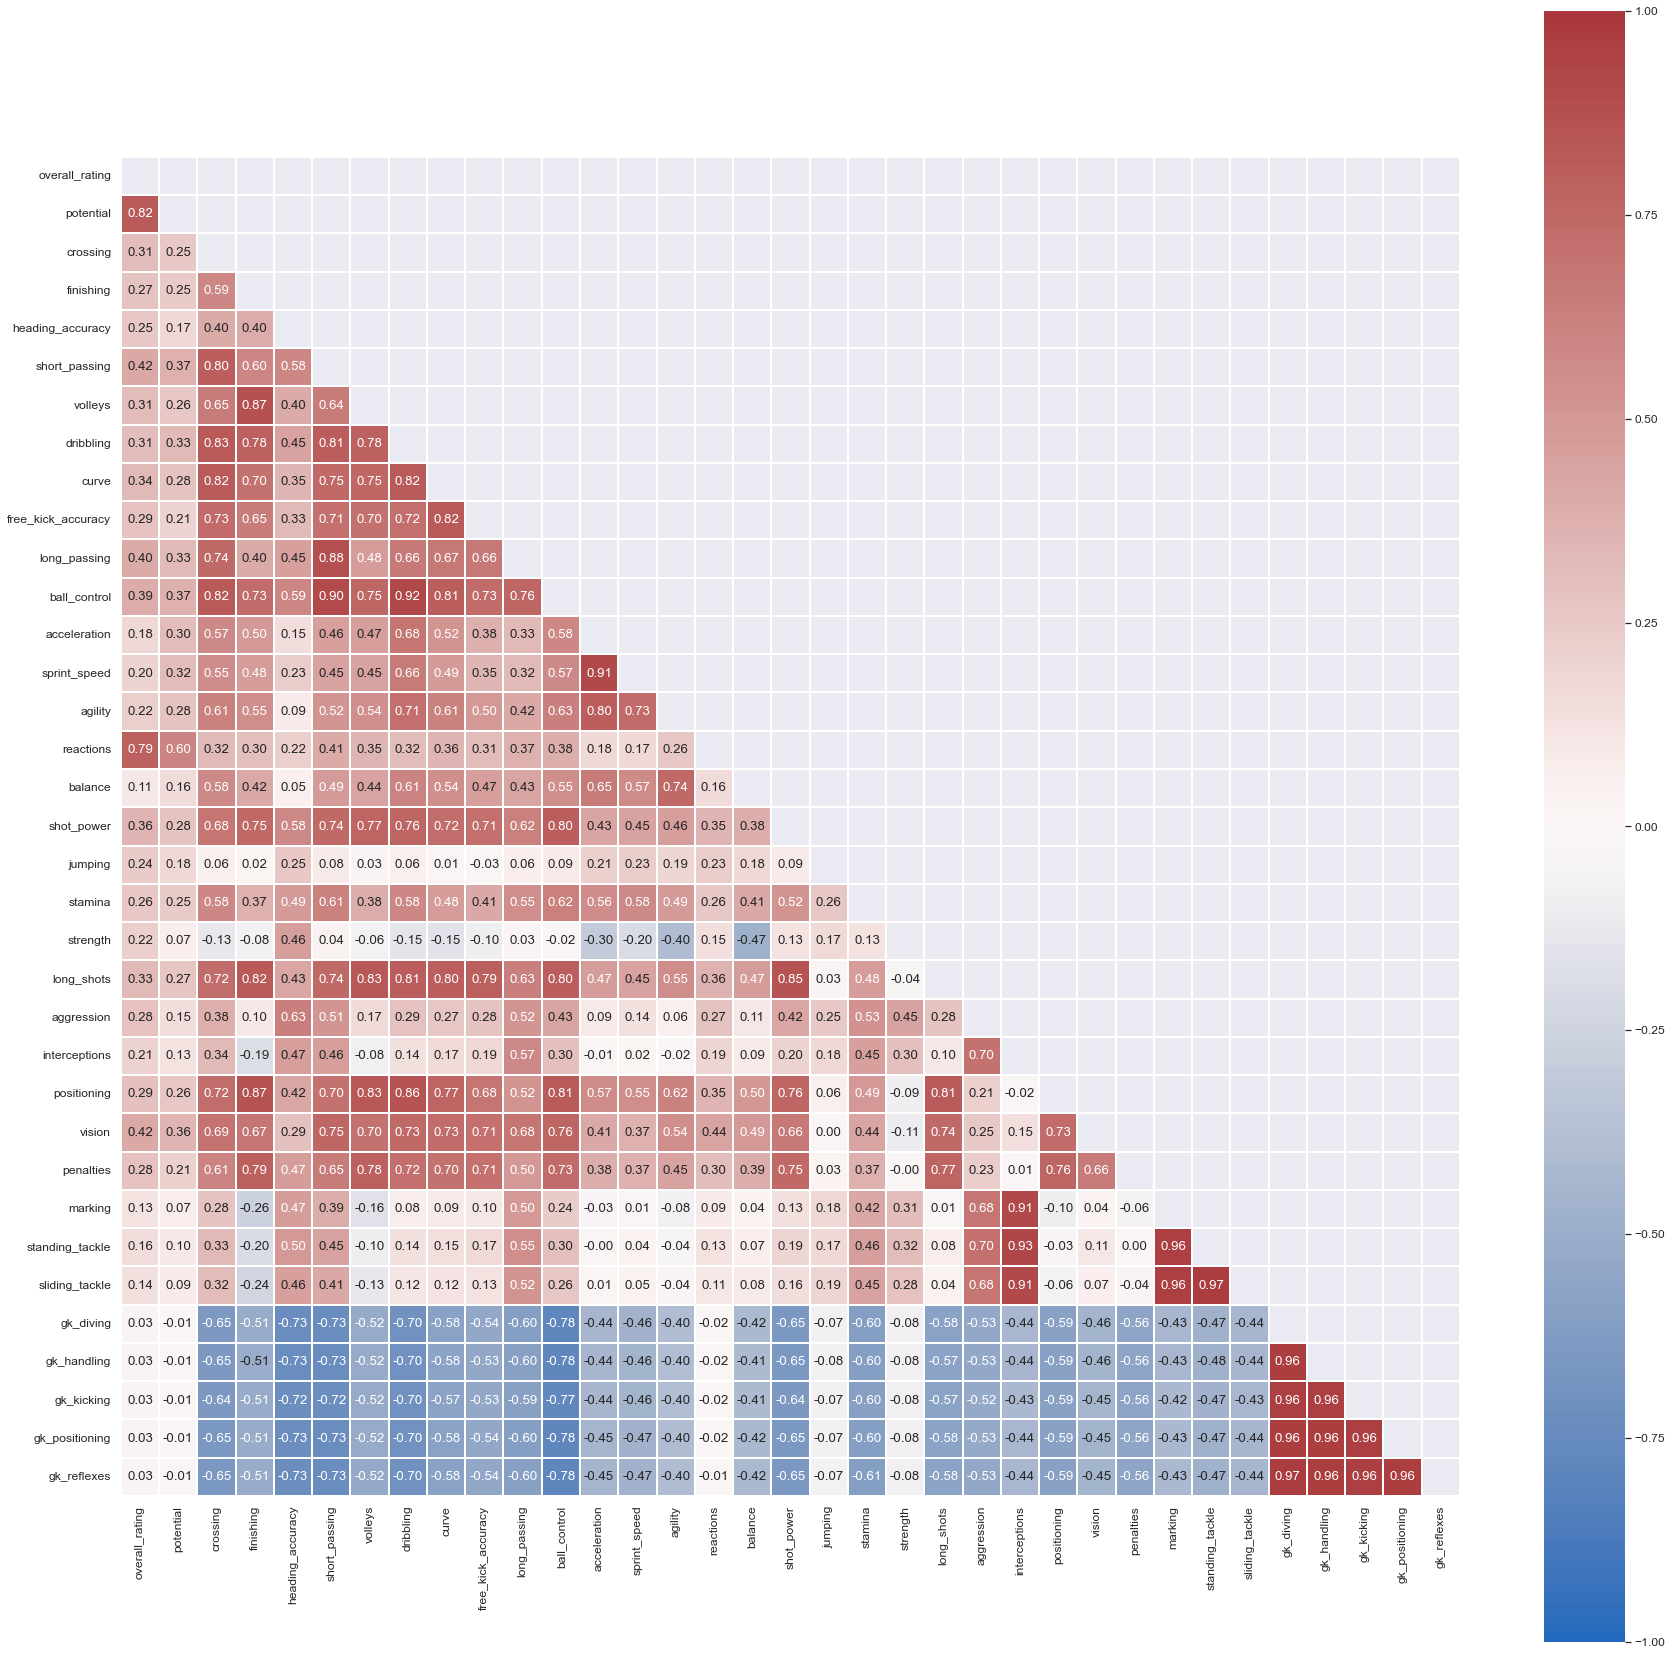

In [195]:
target = 'agility'
features_to_drop = []

correlation_matrix = DF_TRAIN.corr()
display(correlation_matrix)
corr_mask = np.triu(np.full(correlation_matrix.shape, True))
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix,
            square=True, annot=True, fmt='.2f', center=0,
            linewidth=2, cmap='vlag', mask=corr_mask, vmin=-1, vmax=1)
plt.show()

Let's check which features do not correlate with agility ($|r|<0.25$). We can drop these features from the dataframe.

In [196]:
corr_matrix_target: pd.Series = correlation_matrix[target]
no_corr_features = corr_matrix_target[corr_matrix_target.abs() < 0.25].index.to_list()
print(no_corr_features)
features_to_drop += no_corr_features

['overall_rating', 'heading_accuracy', 'jumping', 'aggression', 'interceptions', 'marking', 'standing_tackle', 'sliding_tackle']


Now let's turn again to the correlation matrix (heatmap) and try to visually detect multicollinearity. One sign of this is that the features have the same or similar collinearity value between them, and the target also has the same collinearity values for these features. A set of features `gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes` fits under such parameters. We can remove all but one of these parameters. In this case, the contribution of all these parameters to the target will still be taken into account (since there is a strong correlation between them). We will keep the `gk_reflexes` parameter, and remove the others from the sample

In [197]:
features_to_drop += ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning']

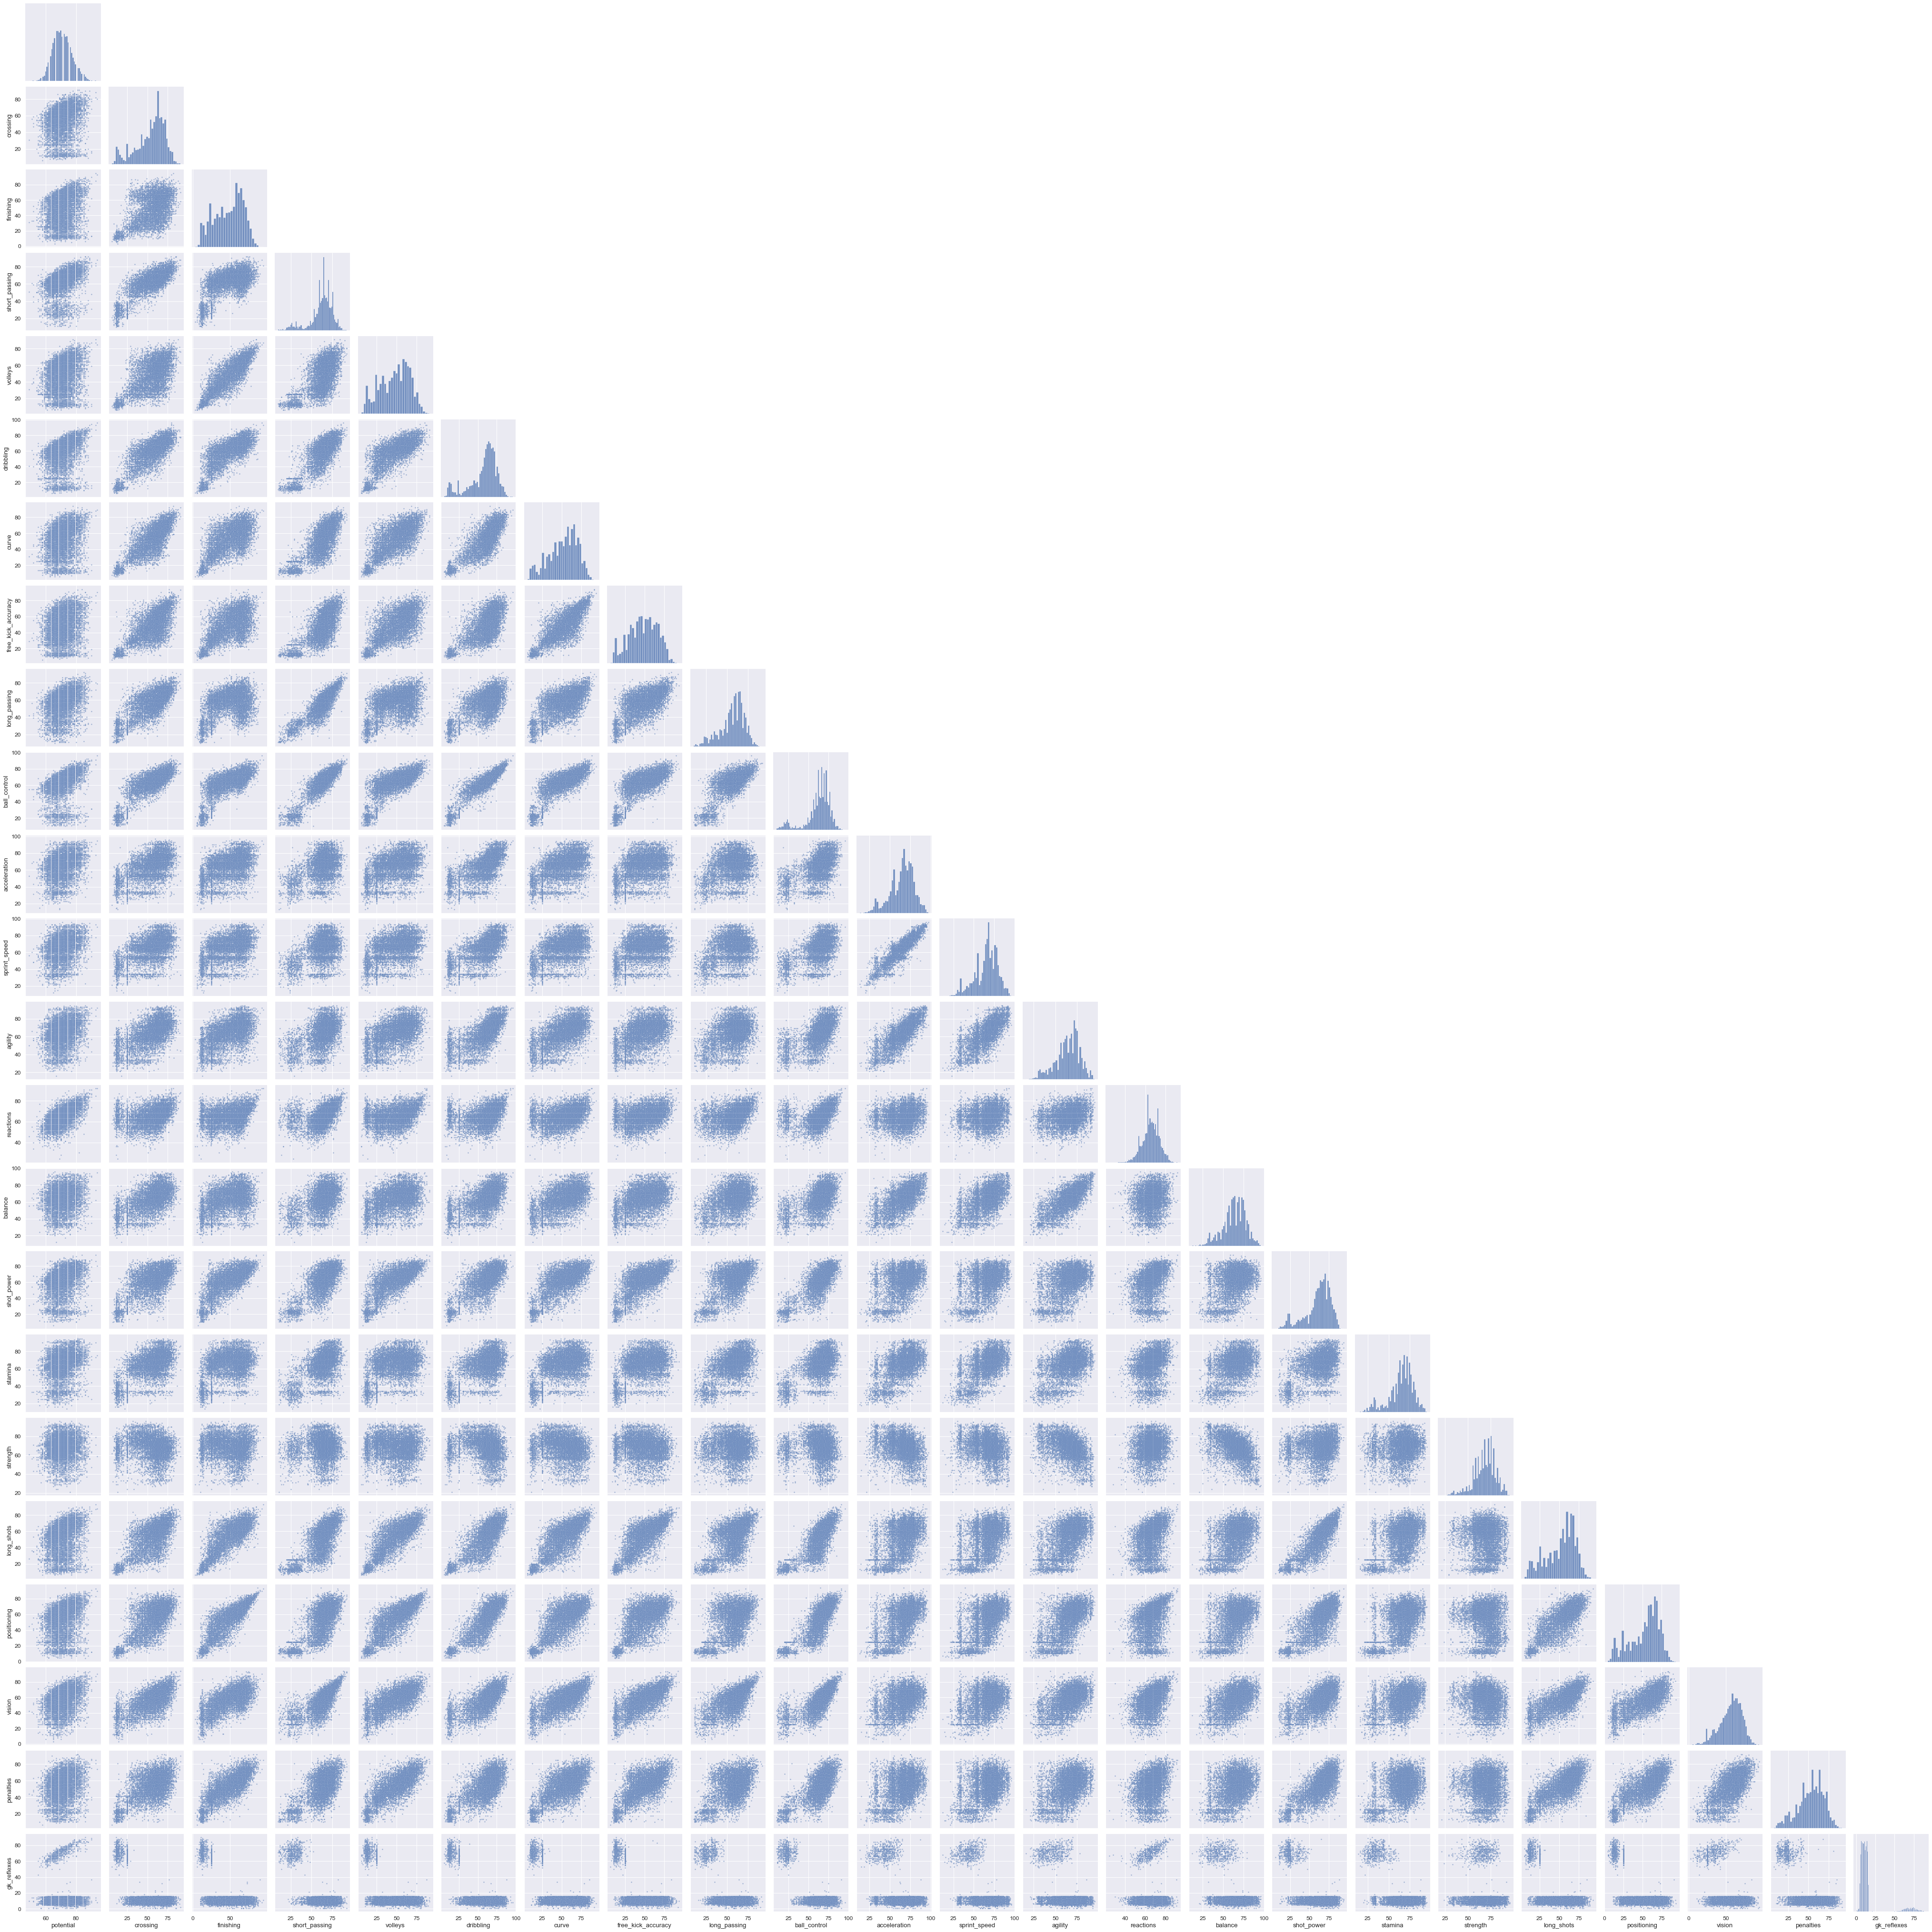

In [198]:
tmp_df_train = DF_TRAIN.drop(pd.Index(features_to_drop), axis=1)
sns.pairplot(tmp_df_train, plot_kws={'s': 7, 'alpha': 0.5}, corner=True);

As we can see, the `gk_reflexes` feature has a strange distribution, and I think that this also should be removed. Also we can remove `potential` because there is a kind of normal distribution with the agility centered at 50

In [199]:
features_to_drop += ['gk_reflexes', 'potential']
print(f'After all we have {len(features_to_drop)} features to remove ({features_to_drop}) and that leaves us with {DF_TRAIN.shape[1] - len(features_to_drop) - 1} features')

After all we have 14 features to remove (['overall_rating', 'heading_accuracy', 'jumping', 'aggression', 'interceptions', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'potential']) and that leaves us with 20 features


Now let's analyze the features based on their descriptions and drop those features that in our opinion should not correlate with agility
**Target**:
* **Agility** - determines how quick and graceful a player is able to control the ball. Agility depends on both mental and physical skills of the player.

**Features**:
1. **Acceleration** determines the increment of a player's running speed (sprint speed) on the pitch. The acceleration rate specifies how fast a player can reach their maximum sprint speed.
2. **Balance** determines the even distribution of enabling a player to remain upright and steady when running, carrying and controlling the ball.
3. **Ball control** determines the ability of a player to control the ball on the pitch.
4. **Crossing** determines the accuracy and the quality of a player's crosses.
5. **Curve** determines a player's ability to curve the ball when passing and shooting.
6. **Dribbling** determines a player's ability to carry the ball and past an opponent while being in control.
7. **Finishing** determines the ability of a player to score (ability for finishing - How well they can finish a opportunity with a score).
8. **Free Kick Accuracy** determines a player's accuracy for taking the Free Kicks.
9. **Long Passing** determines a player's accuracy for the long and aerial passes.
10. **Long Shot** determines a player's accuracy for the shots taking from long distances.
11. **Penalties** determine a player's accuracy for the shots taking from the penalty kicks.
12. **Positioning** determines that how well a player is able to perform the positioning on the field as a player or on the goal line as a goalkeeper.
13. **Reactions** determines the acting speed of a player in response to the situations happening around them.
14. **Short Passing** determines a player's accuracy for the short passes.
15. **Shot Power** determines the strength of a player's shootings.
16. **Sprint Speed** determines the speed rate of a player's sprinting (running).
17. **Stamina** determines a player's ability to sustain prolonged physical or mental effort in a match.
18. **Strength** determines the quality or state of being physically strong of a player.
19. **Vision** determines a player's mental awareness about his teammates' positioning, for passing the ball to them.
20. **Volleys** determines a player's ability for performing volleys.

Below will be a list of correlating traits that have a similar description and high degree of correlation. In the following, the groups of features will be combined using linear combination.
* **Acceleration** and **Sprint Speed** features by description look related and also have a strong correlation equal to 0.91
* **Crossing**, **Short Passing** and **Long Passing** features are described as ball passes, have a good correlation (see [appendix 1](#Appendix-1)), and can be combined
* **Shot power** and **Long Shots** features by description and meaning look related and also have a strong correlation equal to 0.85

Below is a list of features that do not fit the description of agility prediction
* **Vision**
* **Positioning**

Now let's process the dataset based on our findings

In [200]:
features_to_drop += ['acceleration', 'sprint_speed', 'crossing', 'short_passing', 'long_passing', 'shot_power', 'long_shots', 'vision', 'positioning']

In [201]:
DF_TRAIN_MOD = DF_TRAIN.copy()
DF_TEST_MOD = DF_TEST.copy()

DF_TRAIN_MOD['dynamics'] = DF_TRAIN_MOD['acceleration'] + DF_TRAIN_MOD['sprint_speed']
DF_TRAIN_MOD['passing'] = DF_TRAIN_MOD['crossing'] + DF_TRAIN_MOD['short_passing'] + DF_TRAIN_MOD['long_passing']
DF_TRAIN_MOD['kick_power'] = DF_TRAIN_MOD['shot_power'] + DF_TRAIN_MOD['long_shots']
DF_TEST_MOD['dynamics'] = DF_TEST_MOD['acceleration'] + DF_TEST_MOD['sprint_speed']
DF_TEST_MOD['passing'] = DF_TEST_MOD['crossing'] + DF_TEST_MOD['short_passing'] + DF_TEST_MOD['long_passing']
DF_TEST_MOD['kick_power'] = DF_TEST_MOD['shot_power'] + DF_TEST_MOD['long_shots']

In [202]:
features = DF_TRAIN_MOD.columns.difference(features_to_drop + [target]).tolist()
print('List features to drop:' + ', '.join(features_to_drop))
print('---')
print('List of features: ' + ', '.join(features))

List features to drop:overall_rating, heading_accuracy, jumping, aggression, interceptions, marking, standing_tackle, sliding_tackle, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes, potential, acceleration, sprint_speed, crossing, short_passing, long_passing, shot_power, long_shots, vision, positioning
---
List of features: balance, ball_control, curve, dribbling, dynamics, finishing, free_kick_accuracy, kick_power, passing, penalties, reactions, stamina, strength, volleys


Now, lets visualize correlation matrix for selected features by heatmap

balance  ball_control     curve  dribbling  dynamics  \
balance             1.000000      0.552797  0.541547   0.605007  0.623895   
ball_control        0.552797      1.000000  0.807772   0.918540  0.590104   
curve               0.541547      0.807772  1.000000   0.817182  0.513369   
dribbling           0.605007      0.918540  0.817182   1.000000  0.683829   
dynamics            0.623895      0.590104  0.513369   0.683829  1.000000   
finishing           0.420727      0.732182  0.698224   0.784504  0.499101   
free_kick_accuracy  0.467431      0.728906  0.821925   0.716390  0.374770   
kick_power          0.446386      0.830802  0.793304   0.818192  0.478492   
passing             0.540383      0.889593  0.804104   0.824478  0.500196   
penalties           0.387038      0.730424  0.702778   0.716010  0.386717   
reactions           0.162888      0.384052  0.355061   0.317949  0.180658   
stamina             0.410493      0.624025  0.478749   0.582936  0.580290   
strength           -0.470045     -0.021480 -0.149845  -0.146671 -0.257999   
volleys             0.439412      0.751873  0.751440   0.782282  0.467700   
agility             0.741794      0.625286  0.610468   0.711282  0.785010   

                    finishing  free_kick_accuracy  kick_power   passing  \
balance              0.420727            0.467431    0.446386  0.540383   
ball_control         0.732182            0.728906    0.830802  0.889593   
curve                0.698224            0.821925    0.793304  0.804104   
dribbling            0.784504            0.716390    0.818192  0.824478   
dynamics             0.499101            0.374770    0.478492  0.500196   
finishing            1.000000            0.646091    0.816074  0.572888   
free_kick_accuracy   0.646091            1.000000    0.785042  0.751090   
kick_power           0.816074            0.785042    1.000000  0.767561   
passing              0.572888            0.751090    0.767561  1.000000   
penalties            0.789741            0.705693    0.787341  0.627415   
reactions            0.299517            0.314620    0.370806  0.391016   
stamina              0.367918            0.412151    0.516444  0.624120   
strength            -0.077052           -0.099090    0.041458 -0.028057   
volleys              0.870025            0.699354    0.832250  0.636489   
agility              0.547516            0.496754    0.527960  0.562013   

                    penalties  reactions   stamina  strength   volleys  \
balance              0.387038   0.162888  0.410493 -0.470045  0.439412   
ball_control         0.730424   0.384052  0.624025 -0.021480  0.751873   
curve                0.702778   0.355061  0.478749 -0.149845  0.751440   
dribbling            0.716010   0.317949  0.582936 -0.146671  0.782282   
dynamics             0.386717   0.180658  0.580290 -0.257999  0.467700   
finishing            0.789741   0.299517  0.367918 -0.077052  0.870025   
free_kick_accuracy   0.705693   0.314620  0.412151 -0.099090  0.699354   
kick_power           0.787341   0.370806  0.516444  0.041458  0.832250   
passing              0.627415   0.391016  0.624120 -0.028057  0.636489   
penalties            1.000000   0.304722  0.371872 -0.001457  0.781403   
reactions            0.304722   1.000000  0.258210  0.145111  0.348653   
stamina              0.371872   0.258210  1.000000  0.127918  0.384748   
strength            -0.001457   0.145111  0.127918  1.000000 -0.064989   
volleys              0.781403   0.348653  0.384748 -0.064989  1.000000   
agility              0.448094   0.260984  0.490533 -0.403731  0.540948   

                     agility  
balance             0.741794  
ball_control        0.625286  
curve               0.610468  
dribbling           0.711282  
dynamics            0.785010  
finishing           0.547516  
free_kick_accuracy  0.496754  
kick_power          0.527960  
passing             0.562013  
penalties           0.448094  
reactions           0.260984  
stamina             0.490533  

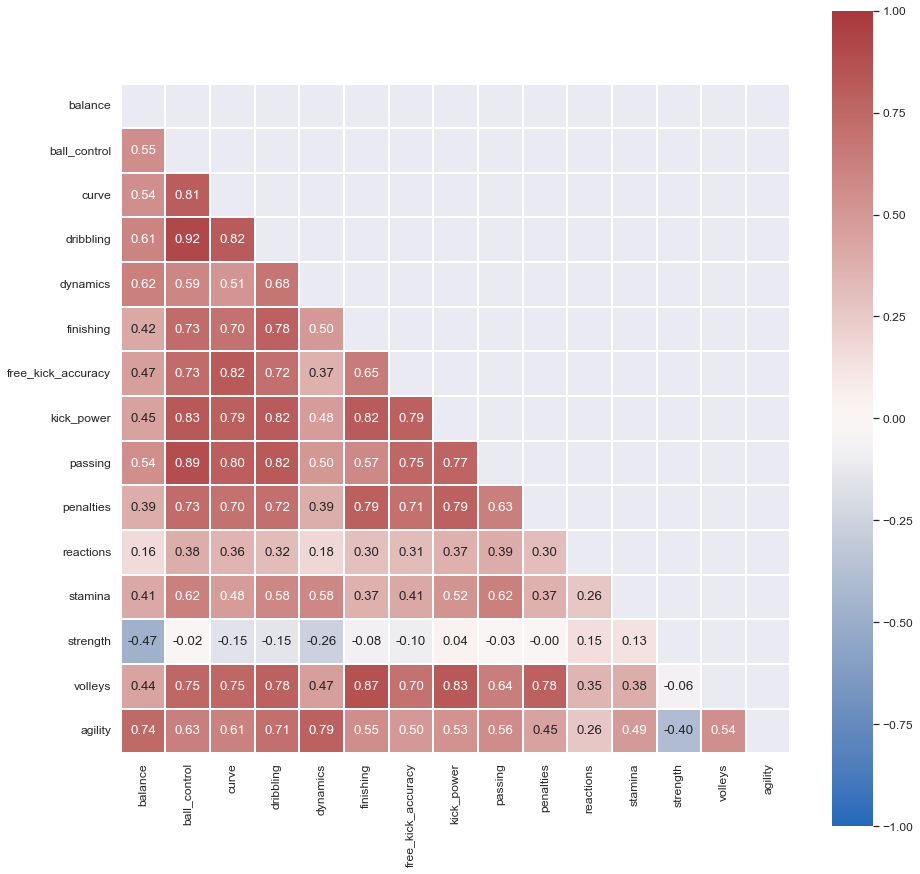

In [203]:
correlation_matrix = DF_TRAIN_MOD[features + [target]].corr()
display(correlation_matrix)
corr_mask = np.triu(np.full(correlation_matrix.shape, True))
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix,
            square=True, annot=True, fmt='.2f', center=0,
            linewidth=2, cmap='vlag', mask=corr_mask, vmin=-1, vmax=1)
plt.show()

In general, additional collinear and multicollinear features can be found among the features on this matrix, but the study of collinear and multicollinear features was conducted above. There is also suspicious behavior, such as that of the `strength` feature. However, as I believe the selected features will contribute sufficiently to the prediction, but their collinearity will not contribute much.

In [204]:
def get_train_test_data(
        features: List[str], target: str
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Return x_train, y_train, x_test, y_test using
    * global train/test split
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables.
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(),
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )
x_train, y_train, x_test, y_test = \
    DF_TRAIN_MOD[features].copy(), DF_TRAIN_MOD[target].copy(), \
    DF_TEST_MOD[features].copy(), DF_TEST_MOD[target].copy()

model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')
model_preds = model.predict(x_test)
metrics_test_2 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_2

model_intercept: 13.072475381010875
model_coef: [ 0.26867209 -0.0118296   0.05636639  0.12977326  0.20164595  0.04121681
  0.0278987  -0.0163845  -0.0180781  -0.03749902  0.15211725  0.04081682
 -0.17523939  0.02174938]


mse     47.617797
mae      5.200969
mape     0.093957
r2       0.758647
dtype: float64

As we see here there are no large values of both coefficients and metrics from which we can judge that collinearity among the variables is not detected or it does not contribute sufficiently.

In [205]:
print(f'L2-norm value: {l2_norm(model.coef_)}')

L2-norm value: 0.4398524148679793


$L_2$-norm value is within reasonable limits from which we can judge that multicollinearity is also not detected or does not contribute sufficiently

Here was the work done to build a linear regression model to predict the agility feature. The resulting model showed that it has a good correlation ($R^2=0.75$) and small errors ($MSE=47.62, MAE=5.20, MAPE=0.09$) with the test data. These results can be explained for several reasons:
* The most appropriate traits for predicting dexterity were chosen
* Agility is a rather general parameter, because of which it depends on many other features and affects many other features as well.
* Accordingly, where agility is the main and dominant one, there will be a high correlation with selected feature.

The reasons for the high correlation between the other features include the fact that some of them are highly correlated (e.g. long and short passes), both in terms of technique and the player's body abilities.

This model could be improved by spending more time studying the raw data and applying a different method of combining features.

The presented model can be used, for example, for training program planning or player style analysis.

# Appendix 1

In [206]:
print('Correlation matrix 1')
display(DF_TRAIN[['crossing', 'long_passing', 'short_passing']].corr())

Correlation matrix 1


crossing  long_passing  short_passing
crossing       1.000000      0.741020       0.802589
long_passing   0.741020      1.000000       0.877881
short_passing  0.802589      0.877881       1.000000

# Appendix 2

Here I tried to perform an automatic search for mutually correlated groups of features. I think the most interesting groups are groups 4 and 5

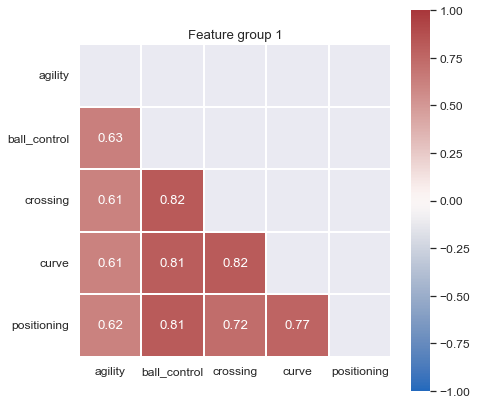

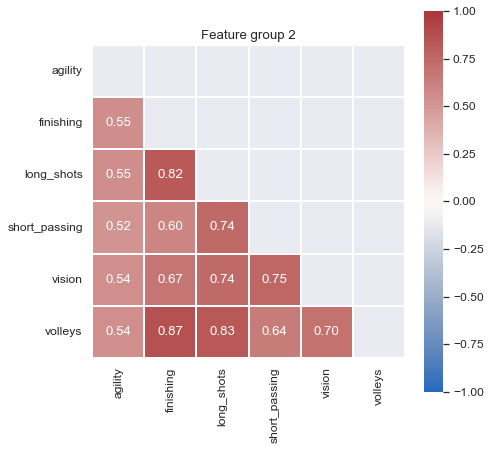

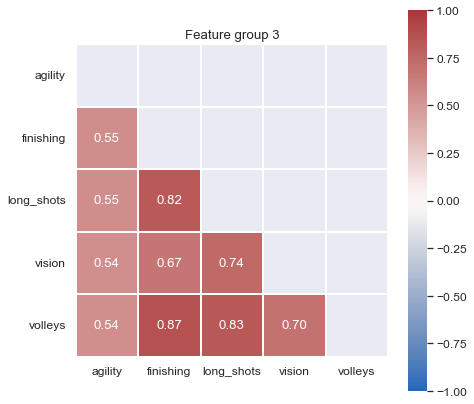

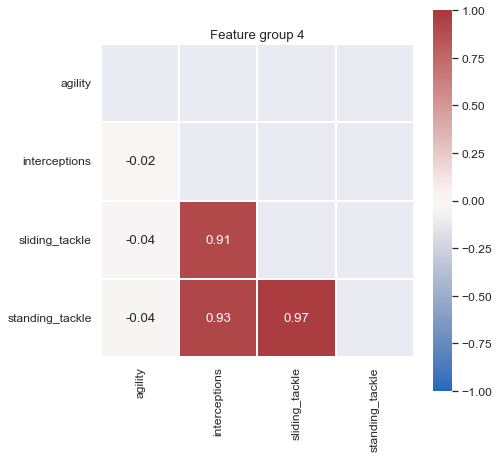

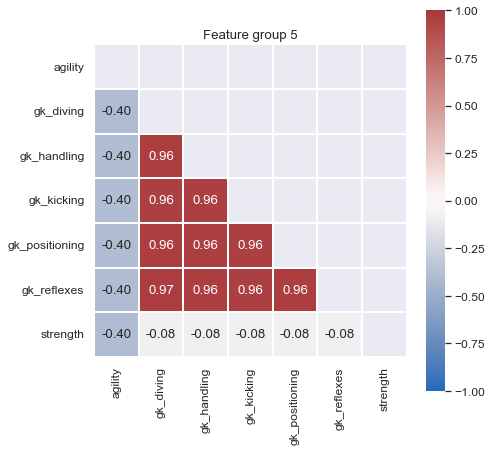

In [207]:
def plot_heatmap(data: pd.DataFrame, title: str = ''):
    plot_mask = np.triu(np.full(data.shape, True))
    plt.figure(figsize=(7, 7))
    sns.heatmap(data,
            square=True, annot=True, fmt='.2f', center=0,
            linewidth=2, cmap='vlag', mask=plot_mask, vmin=-1, vmax=1)
    plt.title(title)
    plt.yticks(rotation=0)
    plt.show()

def check_corr_feature_groups(value_bias = 0.03, correlation_value_border=0.8):
    similar_values_features = []
    wo_no_corr = correlation_matrix.drop(columns=no_corr_features)[target]
    wo_target = wo_no_corr.drop(index=[target])
    for feature in wo_target.index:
        wo_check_feature = wo_target.drop(index=[feature])
        feature_value = wo_target[feature]
        feature_group = wo_check_feature[
            (wo_check_feature - feature_value).abs() < value_bias]

        if feature_group.shape[0] > 0:
            corr_feature_group = correlation_matrix[feature]\
                    .drop(index=correlation_matrix.columns
                        .difference(feature_group.index.tolist()))
            strong_corr = corr_feature_group[corr_feature_group > correlation_value_border]

            if strong_corr.shape[0] > 0:
                feature_set = set(feature_group.index.tolist() + [feature])
                if feature_set not in similar_values_features:
                    similar_values_features.append(feature_set)

    for i_set, feature_set in enumerate(similar_values_features):
        feature_list = list(feature_set) + [target]
        feature_list.sort()
        plot_heatmap(correlation_matrix.loc[feature_list, feature_list],
                     title=f'Feature group {i_set + 1}')

correlation_matrix = DF_TRAIN.corr()
check_corr_feature_groups()